In [5]:
import torch
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


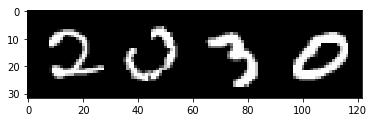

    2     0     3     0


In [18]:
import matplotlib as plt

# functions to show an image

classes = [i for i in range(10)]
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.distributions import Uniform

class mlp_layer(nn.Module):
    def __init__(self,d_in, d_out, activation):
        """
        Activation is a function (eg. torch.nn.functional.sigmoid/relu)
        """
        super().__init__()
        self.mu = nn.Linear(d_in, d_out)
        self._init_weights(d_in, d_out)
        self.activation = activation
    
    def forward(self,x):
        return self.activation(self.mu(x))

    def _init_weights(self, input_size, output_size, constant=1.0):
        scale = constant*np.sqrt(6.0/(input_size + output_size))
        assert(output_size > 0)
        nn.init.uniform_(self.mu.weight, -scale, scale)
        nn.init.zeros_(self.mu.bias)


In [21]:
from torch.distributions import Normal
import copy


class bayesian_mlp_layer(mlp_layer):
    def __init__(self,d_in, d_out, activation):
        """
        Activation is a function (eg. torch.nn.functional.sigmoid/relu)
        """
        super().__init__(d_in,d_out,activation)
        self.log_sigma = nn.Linear(d_in, d_out)
        self.init_log_sigma()
        #mu is initialized the same as non-Bayesian mlp
        
        """
        Attribute for now, but planning to do only "in-place" changes 
        """
        self.weight_sampler = Normal(self.mu.weight, \
                              torch.exp(self.log_sigma.weight))
        self.bias_sampler = Normal(self.mu.bias, \
                              torch.exp(self.log_sigma.bias))
        
    def forward(self,x, sampling=True):
        print("BMLP Sampling " + str(sampling))
        if sampling:
            my_lin = nn.Linear(*self.mu.weight.shape)
            my_lin.weight = nn.Parameter(self.weight_sampler.sample())
            my_lin.bias = nn.Parameter(self.bias_sampler.sample())
            return self.activation(my_lin(x))
        else:
            return super().forward(x)
        
        
    def _init_log_sigma(self):
        nn.init.constant_(self.log_sigma.weight, 0.0)
        nn.init.constant_(self.log_sigma.bias, 0.0)
    
    def get_posterior(self):
        return [(self.mu.weight, self.log_sigma.weight),(self.mu.bias, self.log_sigma.bias))


        


In [ ]:
class NormalSamplingLayer:
    def __init__(self,d_out):
        self.d_out
    
    def __call__(self, mu_log_sigma_vec):
        return Normal(mu_log_sigma_vec[:,:d_out], torch.exp(mu_log_sigma_vec[:,d_out:])).sample()

In [12]:
import itertools

class FunctionComposition:
    def __init__(self,f_list):
        assert(len(f_list) > 0)
        for i in range(len(f_list)-1):
            assert(f_list[i].d_out == f_list[i].d_in)
        self.f_list = f_list
    
    def __call__(self, x, *optional):
        for f in self.f_list:
            x = f(x,*optional)
        return x

    @property
    def d_in(self):
        return self.f_list[0].d_in
    
    @property
    def d_out(self):
        return self.f_list[-1].d_out

In [ ]:
import itertools

class BayesianNet(nn.Module, FunctionComposition):
    def __init__(self,f_list):
        super().__init__(f_list)
    
    def get_posterior(self):
        return list(itertools.chain(*list(map(lambda f: f.get_posterior(), self.f_list))))

In [23]:
class NNFactory:
    @classmethod
    def CreateNN(cls, dims, activations):
        assert(len(dims)-1 == len(activations))
        layers = []
        for i in range(len(dims)-1):
            layers.append(bayesian_mlp_layer(dims[i],dims[i+1],activations[i]))
        return FunctionComposition(layers)
    
    @classmethod
    def CreateBayesianNet(cls, dims, activations):
        assert(len(dims)-1 == len(activations))
        layers = []
        for i in range(len(dims)-1):
            layers.append(bayesian_mlp_layer(dims[i],dims[i+1],activations[i]))
        return BayesianNet(layers)

In [ ]:
def KL_div_gaussian(mu_q, log_sig_q, mu_p, log_sig_p): 
    """
    KL(q||p), gets log of sigma rather than sigma
    """
    return log_sig_p - log_sig_q + (0.5)*torch.exp(-2*log_sig_p)*(torch.exp(log_sig_q)**2 + (mu_q - mu_p)**2)-1/2

In [ ]:
def KL_div_gaussian_from_standard_normal(mu_q, log_sig_q):
    #0,0 corresponds to N(0,1) due to the log_sig representation, works for multidim normal as well.
    return KL_div_gaussian(mu_q, log_sig_q, 0.0, 0.0) 

In [ ]:
def Zs_to_mu_sig(Zs):
    dimZ = Zs.shape[1]//2 #1st is batch size 2nd is 2*dimZ
    mu_qz = Zs_params[:,:dimZ]
    log_sig_qz  = Zs_params[:,dimZ:]
    return mu_qz, log_sig_qz 

In [ ]:
forced_interval = (1e-9, 1.0)
def log_bernouillli(X, Mu_Reconstructed_X):
    """
    Mu_Reconstructed_X is the output of the decoder. We accept fractions, and project them to the interval 'forced_interval' for numerical stability
    """
    logprob =    x      * torch.log(torch.clamp(Mu_Reconstructed_X,         *forced_interval) \
              + (1 - x) * torch.log(torch.clamp((1.0 - Mu_Reconstructed_X), *forced_interval)
    return torch.sum(logprob, dim=logprob.dim())

In [ ]:
def log_P_y_GIVEN_x(Xs, enc, sample_and_decode, NumLogPSamples = 100):
    """
    Returns logP(Y|X), KL(Z||Normal(0,1))
    """
    Zs_params = enc(Xs)
    mu_qz, log_sig_qz  = Zs_to_mu_sig(Zs)
    kl_z = KL_div_gaussian_from_standard_normal(mu_qz, log_sig_qz)
    logp = 0.0
    for _ in range(NumLogPSamples):
        #The Zs_params are the deterministic result of enc(Xs) so we don't recalculate them
        Mu_Ys = sample_and_decode(Zs_params)
        logp += log_bernouillli(x, Mu_Ys) / NumLogPSamples
    return logp, kl_z

In [ ]:
class SharedDecoder:
    def __init__(self, dims, activations):
        self.net = NNFactory.CreateBayesianNet(dims, activations)
        self._init_prior()
        
    def __call__(self, Xs):
        return self.net(Xs)
    
    def _init_prior(self):
        """
        Initialize a constant tensor that corresponds to a prior distribution over all the weights
        which is standard normal
        """
        self.prior = [torch.zeros(x.shape) for x in self.net.get_posterior()]
        
    def update_prior(self):
        """
        Copy the current posterior to a constant tensor, which will be used as prior for the next task
        """
        self.prior = [x.clone.detach() for x in self.net.get_posterior()]
        
    def KL_from_prior(self):
        return sum[KL_div_gaussian(*post, *prior) for (post, prior) in zip(self.net.get_posterior(), self.prior)]
    
    @property
    def d_in(self):
        return self.net.d_in
    
    @property
    def d_out(self):
        return self.net.d_out
            

In [ ]:
import torch.nn as nn
import torch.optim 

#BayesianVAE
class TaskModel(nn.Module):
    def __init__(self, enc, dec_head, dec_shared, learning_rate = 1e-4):
        self.enc = enc
        self.dec_head = dec_head
        self.dec_shared = dec_shared
    
        self.sampler = NormalSamplingLayer(self.dec_head.d_in)
        self.sample_and_decode = FunctionComposition([self.sampler, self.dec_head, self.dec_shared])
 
        #update just before training
        self.DatasetSize = None
        
        #Guards from retraining- train only once
        self.TrainGuard = True
        
        self.optimizer = self._create_optimizer(learning_rate)
        return
    
    def forward(self, Xs):
        logp, kl_z = log_P_y_GIVEN_x(Xs, self.enc, self.sample_and_decode)
        kl_shared_dec_Qt_2_PREV_Qt = self.dec_shared.KL_from_prior()
        #We ignore the kl(private dec || Normal(0,1) ) like the authors did
        ELBO = torch.mean(logp) - torch.mean(kl_z) - (kl_shared_dec_Qt_2_PREV_Qt / self.DatasetSize)
        return -ELBO
    
    def _create_optimizer(self, learning_rate):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def _update_prior(self):
        self.dec_shared.update_prior()
        #no other priors should be updated. they are trained once.
        return
    
    def train(self, n_epochs, task_trainloader):
        #We don't intend a TaskModel to be trained more than once
        assert(self.TrainGuard)
        self.TrainGuard = False
        
        self.DatasetSize = len(task_trainloader.dataset)
        #This will set the prior to the current posterior, before we start to change it during training
        self._update_prior()
        # loop over the dataset multiple times
        for epoch in range(n_epochs):  
            running_loss = 0.0
            for i, data in enumerate(task_trainloader, 0):
                # get the inputs
                inputs, labels = data
        
                # step
                self.optimizer.zero_grad()
                loss = self(inputs)
                loss.backward()
                self.optimizer.step()
        
                # print statistics
                running_loss += loss.item() #?
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
        self.DatasetSize = None
    


In [ ]:
def create_mnist_single_digit_loaders():
    return

In [ ]:
dimX=28*28
dimH=500
dimZ=50

#Shared decoder
dec_shared_dims=[dimH, dimH, dimX]
dec_shared_activations=[F.relu,torch.sigmoid]

#Encoder
enc_dims=[dimX, dimH, dimH, dimZ*2]
enc_activations=[F.relu,F.relu,lambda x:x]

#Private decoder (Head)
dec_head_dims=[dimZ, dimH, dimH]
dec_head_activations=[F.relu,F.relu]



def main():
    dec_shared = SharedDecoder(dec_shared_dims, dec_shared_activations) 
    
    #TODO: check dec_shared.parameters()
    
    #this can be any iterable
    task_loaders = create_mnist_single_digit_loaders()
    
    models = []
    
    #this may train the classifier to generate test_classifier
    #evaluator = Evaluations()
    
    #A task corresponds to a digit
    for task_id, loader in enumerate(task_loaders):
        task_model = TaskModel(NNFactory.CreateNN(enc_dims, enc_activations), \
                               NNFactory.CreateNN(dec_head_dims,dec_head_activations), \
                               dec_shared)
        models.append(task_model)
        optimizer = create_optimizer(task_model.get_trainable_paramaters(), learning params)
        task_model.train(n_epochs, loader, optimizer)
        #make sure you don't change the model params inside the eval 
        #evaluator.create_task_evaluations(models)
    
    #evaluator.report_results()


In [1]:
class A:
    def __init__(self):
        self.a = 3
    
    @property
    def b(self):
        return 4

c = A()
print(c.b)

4
